In [4]:
import pywikibot
from pywikibot import pagegenerators
from pywikibot import userlib
import mwparserfromhell as pfh
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime
import scipy.stats as ss
import operator
import os
import json
import re
import MySQLdb

%pylab inline


enwp, dewp, frwp = (pywikibot.Site(lang, 'wikipedia') for lang in ['en', 'de', 'fr'])

VERBOSE:pywiki:Starting 1 threads...


Populating the interactive namespace from numpy and matplotlib


In [5]:
#Infonoise metric of Stvilia (2005) in concept, although the implementation may differ since we are not stopping and stemming words, because of the multiple languages we need to handle

def readable_text_length(wikicode):
    #could also use wikicode.filter_text()
    return float(len(wikicode.strip_code()))

def infonoise(wikicode):
    wikicode.strip_code()
    ratio = readable_text_length(wikicode) / float(len(wikicode))
    return ratio

#Helper function to mine for section headings, of course if there is a lead it doesn't quite make sense.

def section_headings(wikicode):
    sections = wikicode.get_sections()
    sec_headings = map( lambda s: filter( lambda l: l != '=', s), map(lambda a: a.split(sep='\n', maxsplit=1)[0], sections))
    return sec_headings

#i don't know why mwparserfromhell's .fitler_tags() isn't working at the moment. going to hack it for now
import re
def num_refs(wikicode):
    text = str(wikicode)
    reftags = re.findall('<(\ )*?ref', text)
    return len(reftags)

def article_refs(wikicode):
    sections = wikicode.get_sections()
    return float(reduce( lambda a,b: a+b ,map(num_refs, sections)))

#Predicate for links and files in English French and Swahili

def link_a_file(linkstr):
    fnames = [u'File:', u'Fichier:', u'Image:', u'Picha:']
    bracknames = map(lambda a: '[[' + a, fnames)
    return any(map(lambda b: linkstr.startswith(b), bracknames))

def link_a_cat(linkstr):
    cnames =[u'Category:', u'Catégorie:', u'Jamii:']
    bracknames = map(lambda a: '[[' + a, cnames)
    return any(map(lambda b: linkstr.startswith(b), bracknames))

def num_reg_links(wikicode):
    reg_links = filter(lambda a: not link_a_file(a) and not link_a_cat(a), wikicode.filter_wikilinks())
    return float(len(reg_links))

def num_file_links(wikicode):
    file_links = filter(lambda a: link_a_file(a), wikicode.filter_wikilinks())
    return float(len(file_links))

def report_actionable_metrics(wikicode, completeness_weight=0.8, infonoise_weight=0.6, images_weight=0.3):
    completeness = completeness_weight * num_reg_links(wikicode)
    informativeness = (infonoise_weight * infonoise(wikicode) ) + (images_weight * num_file_links(wikicode) )
    numheadings = len(section_headings(wikicode))
    articlelength = readable_text_length(wikicode)
    referencerate = article_refs(wikicode) / readable_text_length(wikicode)

    return {'completeness': completeness, 'informativeness': informativeness, 'numheadings': numheadings, 
            'articlelength': articlelength, 'referencerate': referencerate}

def calculate_article_metric(article_name, metric):
    page = pywikibot.Page(enwp, article_name)
    page_text = page.get()
    wikicode = pfh.parse(page_text)
    metrics = report_actionable_metrics(wikicode)
    return metrics[metric]

In [6]:
def calculate_edit_hours(user, cursor):
    starttime = datetime.datetime.now()
    qstring = u'''SELECT rev_timestamp FROM enwiki_p.revision_userindex WHERE rev_user_text like "'''+ user + u'''";'''
    uqstring = qstring.encode('utf-8')
    cursor.execute(uqstring)
    results = cursor.fetchall()
    clean_results = map(lambda t: t[0], results)
    timestamps = map(pywikibot.Timestamp.fromtimestampformat, clean_results)
    #print len(timestamps)                                                                                                                                     
    edit_sessions = []
    curr_edit_session = []

    prev_timestamp = datetime.datetime(year=2001, month=1, day=1)


    for contrib in timestamps:
        curr_timestamp = contrib

        #if curr_timestamp > snapshot_timestamp:                                                                                                               
        #    break                                                                                                                                             
 
        if curr_timestamp-prev_timestamp < datetime.timedelta(hours=1):
            curr_edit_session.append(curr_timestamp)
            prev_timestamp = curr_timestamp

        else:
            if curr_edit_session:
                edit_sessions.append(curr_edit_session)
            curr_edit_session = [curr_timestamp]
            prev_timestamp = curr_timestamp

    #finally have to add the curr_edit_session to list                                                                                                         
    if curr_edit_session:
        print 'hea'
        edit_sessions.append(curr_edit_session)


    #print len(edit_sessions)                                                                                                                                  
    def session_length(edit_session):
        avg_time = datetime.timedelta(minutes=4, seconds=30)
        last = edit_session[-1]
        first = edit_session[0]
        span = last - first
        total = span + avg_time
        return total

    session_lengths = map(session_length, edit_sessions)
    second_lens = map(lambda td: td.total_seconds(), session_lengths)
    total_time = sum(second_lens)

    took = datetime.datetime.now() - starttime
    tooksecs = took.total_seconds()
    print 'timestamps per second: ', len(timestamps)/float(tooksecs)
    #returning total hours                                                                                                                                     
    return total_time / float(3600)


In [7]:
if not enwp.logged_in: enwp.login()

In [8]:
class bipartite_data():
    def __init__(self, category_name):
        self.category_name = category_name
        self.enwp = pywikibot.Site('en', 'wikipedia')
        
    def load_arts(self):
        cat = pywikibot.Category(enwp, self.category_name)
        self.articles = list(cat.articles())
    
        def earliest_revision(article):
            revisions  = list(article._revisions.itervalues())
            timestamps = map(lambda r: r.timestamp, revisions)
            earliest = min(timestamps)
            return earliest
        
        def load_all_revisions(article):
            before_count = len(article._revisions)
            #print "before ", before_count
            if before_count == 0:
                article.getVersionHistory()
            else:
                enwp.loadrevisions(page=article, starttime=earliest_revision(article))
            after_count = len(article._revisions)
            #print "after ", after_count
            if before_count == after_count:
                return
            else:
                load_all_revisions(article)
            
        for article in self.articles:
            load_all_revisions(article)
    
    def make_revision_df(self):
        
        def make_rev_dict(article):
            revdict = {rev.timestamp : {'user' : rev.user, 'article' : article.title()} for rev in article._revisions.itervalues()}
            return revdict
        
        self.all_revisions = pd.DataFrame(columns=['user', 'article'], index=pd.TimeSeries())
        
        for article in self.articles:
            self.all_revisions = self.all_revisions.append(pd.DataFrame.from_dict(data=make_rev_dict(article), orient='index'))
            
    def remove_bots(self):
        self.no_bots = self.all_revisions[self.all_revisions['user'].map(lambda username: not re.findall('bot|stat', username, flags=re.IGNORECASE))]

    def remove_min_editors(self, remove_minimum=5):
            
        user_ar = self.no_bots.groupby(by='user')
        edit_sizes = user_ar.size()
        min_editors = edit_sizes[ edit_sizes > remove_minimum]
    
        criterion = self.no_bots['user'].map(lambda user: user in min_editors.index)
        min_revisions = self.no_bots[criterion]
    
        self.sorted_min_revisions = min_revisions.sort(axis=0)
    
    def make_user_art_dicts(self):
        u_grouped = self.sorted_min_revisions.groupby('user')
        a_grouped = self.sorted_min_revisions.groupby('article')
        
        '''these dicts are so we can back translate the indexes in the matrix to real users and articles'''
        users = list(u_grouped.groups.iterkeys())
        articles = list(a_grouped.groups.iterkeys())
        self.user_dict = {username: users.index(username) for username in users}
        self.article_dict = {articlename: articles.index(articlename) for articlename in articles}
        
    def make_contributor_matrix(self):
    
        ua_grouped = self.sorted_min_revisions.groupby(by = ['user', 'article'])
        self.contributor_matrix = np.zeros(shape=(len(self.user_dict), len(self.article_dict)))

        for user_article_tuple, timestamps in ua_grouped.groups.iteritems():
            user_string = user_article_tuple[0]
            article_string = user_article_tuple[1]
            user_index = self.user_dict[user_string]
            article_index = self.article_dict[article_string]
            
            self.contributor_matrix[user_index][article_index] = len(timestamps)
    
    def rank_exogenous_dict(self, exogenous_dict):
        exogenous_dict_sorted = sorted(exogenous_dict.iteritems(), key=operator.itemgetter(1))
        exogenous_ranks_sorted = [(identup[0], exogenous_dict_sorted.index(identup)) for identup in exogenous_dict_sorted]
        return exogenous_ranks_sorted
    
    def make_exogenous_article_metrics(self):            
            exogenous_articles = dict()
            
            for article in self.article_dict.iterkeys():
                exogenous_articles[article] = calculate_article_metric(article, 'articlelength')
            
            self.exogenous_articles_ranked = self.rank_exogenous_dict(exogenous_articles)
    
    def make_exogenous_user_metrics(self):
        exogenous_users = dict()
        '''
        conn = MySQLdb.connect(host='enwiki.labsdb', db="enwiki_p", port=3306, read_default_file="~/replica.my.cnf") 
        cursor = conn.cursor() 
        '''
        for user in self.user_dict.iterkeys():
            #exogenous_users[user] = calculate_edit_hours(user,cursor)
            exogenous_users[user] = len(user)
    
        self.exogenous_users_ranked = self.rank_exogenous_dict(exogenous_users)
    
    def save_everything(self):
        directory = self.category_name
        today = str(datetime.date.today())
        double_directory = 'savedata/' + directory + '/' + today + '/'
        
        if not os.path.exists(double_directory):
            os.makedirs(double_directory)
        
        mfilename = double_directory  + 'M' + '.npy'
        mf = open(mfilename, 'w')
        np.save(mf, self.contributor_matrix)
        
        for filename, filedict in {'user_dict': self.user_dict, 
                                   'article_dict': self.article_dict,
                                   'user_exogenous_ranks': self.exogenous_users_ranked, 
                                   'article_exogenous_ranks': self.exogenous_articles_ranked}.iteritems():
        
            path = double_directory  + filename + '.json'
            f = open(path, 'w')
            json.dump(filedict, f)
    
    def do_everything(self):
        self.load_arts()
        self.make_revision_df()
        self.remove_bots()
        self.remove_min_editors()
        self.make_user_art_dicts()
        self.make_contributor_matrix()
        self.make_exogenous_article_metrics()
        self.make_exogenous_user_metrics()
        self.save_everything()

In [ ]:
def make_snapshots(periods=10):
    period_len = len(min_revisions)/float(periods)
    
    snapshot_dates = list()
    
    for i in range(1, periods+1):
        start = int(0)
        end = int(floor(i*period_len)) - 1
        print "b ",str(start),'   e ',str(end)  
        
        snapshot_dates.append(sorted_min_revisions[start:end].last_valid_index())
        
        snapshots[i] = sorted_min_revisions[start:end]
    
    
    for i, df in snapshots.iteritems():
        directory = name
        today = str(datetime.date.today())
        double_directory = 'savedata/' + directory + '/' + today + '/'
        
        if not os.path.exists(double_directory):
            os.makedirs(double_directory)
        filename = double_directory  + str(i) + '.json'
        f = open(filename, 'w')
        
        snapshots[i].to_json(f)
    
    return {'snapshots': snapshots, 'snapshot_dates':snapshot_dates}

In [9]:
ele = bipartite_data('Category:Deaths_due_to_elephant_attacks')
ele.do_everything()

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


In [28]:
ele.all_revisions.head()

,article,user
2012-08-15 16:48:37,Jacky Boxberger,Gildir
2012-08-15 16:50:03,Jacky Boxberger,Gildir
2012-08-15 16:51:49,Jacky Boxberger,Gildir
2012-08-15 16:58:44,Jacky Boxberger,Gildir
2012-08-15 17:07:06,Jacky Boxberger,Gildir


In [13]:
j = ele.articles[1]

In [ ]:
def text_at_time(article, latest_time):
    

In [22]:
map(lambda a: a[1].timestamp ,  sorted(j._revisions.iteritems(), key=operator.itemgetter(1)) )

[Timestamp(2013, 9, 29, 22, 34, 40),
 Timestamp(2013, 7, 11, 20, 58, 43),
 Timestamp(2013, 7, 7, 16, 58, 24),
 Timestamp(2013, 6, 7, 1, 24, 42),
 Timestamp(2013, 4, 21, 12, 37, 19),
 Timestamp(2012, 12, 30, 9, 22, 17),
 Timestamp(2012, 11, 17, 2, 57, 40),
 Timestamp(2012, 10, 27, 23, 45, 25),
 Timestamp(2012, 10, 26, 8, 29, 37),
 Timestamp(2012, 10, 26, 8, 28, 50),
 Timestamp(2012, 8, 15, 17, 33, 7),
 Timestamp(2012, 7, 29, 1, 56, 17),
 Timestamp(2012, 6, 5, 2, 47, 47),
 Timestamp(2011, 9, 10, 8, 34, 53),
 Timestamp(2011, 8, 14, 3, 20, 24),
 Timestamp(2011, 6, 14, 1, 11, 59),
 Timestamp(2011, 3, 30, 17, 3, 46),
 Timestamp(2011, 2, 9, 21, 29, 15),
 Timestamp(2010, 11, 16, 21, 33, 21),
 Timestamp(2010, 9, 4, 14, 3, 13),
 Timestamp(2010, 7, 17, 22, 11, 13),
 Timestamp(2006, 1, 25, 21, 26, 42),
 Timestamp(2010, 7, 17, 22, 11, 4),
 Timestamp(2010, 7, 14, 6, 49, 2),
 Timestamp(2010, 6, 25, 15, 9),
 Timestamp(2010, 5, 14, 13, 23, 25),
 Timestamp(2010, 5, 4, 0, 56, 41),
 Timestamp(2009, 12, 11

In [68]:
def category_to_save(category_name):
    articles = load_arts(category_name)
    all_revisions = make_revision_df(articles)
    #for removing bot revisons
    save_contributor_matrix_and_user_article_dicts(category_name, all_revisions, periods=10, remove_minimum=5)

In [62]:
def category_to_snapshots(category_name):
    articles = load_arts(category_name)
    all_revisions = make_revision_df(articles)
    #for removing bot revisons
    
    snapshots = make_snapshots(category_name, all_revisions, periods=10, remove_minimum=10)
    snapshot_dates = snapshots['snapshot_dates']
    return snapshots['snapshots']

In [143]:
category_to_save('Category:Liberal_feminism')

removing bot edits
removing editor with less than edits:  5
making contributor matrix
making exogenous article variables
making exogenous user variables
timestamps per second:  67.4370547348
timestamps per second:  1760.55897372
timestamps per second:  2159.55972013
timestamps per second:  1848.16582821
timestamps per second:  2252.41892044
timestamps per second:  2315.86743807
timestamps per second:  2147.07831752
timestamps per second:  2264.22825977
timestamps per second:  2203.81259767
timestamps per second:  95.127408688
timestamps per second:  2232.99961055
timestamps per second:  68.906454566
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 1520.74899557
timestamps per second:  2092.4486547
timestamps per second:  2130.35280114
timestamps per second:  1613.51398008
timestamps per second:  2322.19857048
timestamps per second:  39.2408850782
timestamps per second:  405.861195471
timestamps per second:  2062.12315171
timestamps per second:  2196.8648824
timestamps per second:  1653.00662477
timestamps per second:  205.920441493
timestamps per second:  2126.90352716
timestamps per second:  434.516720847
timestamps per second:  1907.9640752
timestamps per second:  45.8353492399
timestamps per second:  2182.53446928
timestamps per second:  1208.52495837
timestamps per second:  47.3407640799
timestamps per second:  1307.77473384
timestamps per second:  2175.47056639
timestamps per second:  1935.78131467
timestamps per second:  1015.95505136
timestamps per second:  1797.60885569
timestamps per second:  422.757822221
timestamps per second:  195.606755508
timestamps per second:  1950.00258307
timestamps per second:  74.2899843991


In [ ]:
category_to_save('Category:Feminist_writers')

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


removing bot edits
removing editor with less than edits:  5
making contributor matrix
making exogenous article variables
making exogenous user variables
timestamps per second:  218.62898661
timestamps per second:  1037.39818251
timestamps per second:  1486.4050033
timestamps per second:  111.600349005
timestamps per second:  627.301004979
timestamps per second:  136.015151455
timestamps per second:  127.965724144
timestamps per second:  2229.56555013
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 265.002745048
timestamps per second:  712.425294498
timestamps per second:  2192.42596792
timestamps per second:  134.272715784
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 1982.43993055
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 273.449509049
timestamps per second:  293.322239054
timestamps per second:  371.717416409
timestamps per second:  424.701801022
timestamps per second:  413.997345232
timestamps per second:  565.571637944
timestamps per second:  381.278900214
timestamps per second:  303.708254605
timestamps per second:  500.311142504
timestamps per second:  94.8825313009
timestamps per second:  251.510144965
timestamps per second:  594.500442592
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 462.630419168
timestamps per second:  61.6129387171
timestamps per second:  410.613834353
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 49.6346886912
timestamps per second:  319.633365483
timestamps per second:  94.7767097172
timestamps per second:  55.2310143388
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 397.193608629
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 290.44773756
timestamps per second:  384.563901731
timestamps per second:  459.835224401
timestamps per second:  349.221051074
timestamps per second:  37.501464901
timestamps per second:  402.453497527
timestamps per second:  50.0643326675
timestamps per second:  286.001219039
timestamps per second:  527.796232369
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 372.819269035
timestamps per second:  407.342890635
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 284.897691094
timestamps per second:  634.960948462
timestamps per second:  405.977101814
timestamps per second:  330.617136138
timestamps per second:  437.386663383
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 585.190056404
timestamps per second:  178.985001017
timestamps per second:  143.160244033
timestamps per second:  340.751193555
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 335.489686893
timestamps per second:  335.782783522
timestamps per second:  431.521222727
timestamps per second:  497.876702299
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 249.602192576
timestamps per second:  459.488104188
timestamps per second:  1737.84802696
timestamps per second:  23.8011178592
timestamps per second:  423.557947926
timestamps per second:  375.113889813
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 129.161638993
timestamps per second:  268.866784461
timestamps per second:  311.363741334
timestamps per second:  780.349967901
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 174.459407129
timestamps per second:  383.895509666
timestamps per second:  294.029772886
timestamps per second:  50.4432702372
timestamps per second:  29.5156896973
timestamps per second:  519.276981658
timestamps per second:  1060.94197417
timestamps per second:  384.633715501
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 522.291884731
timestamps per second:  455.630368289
timestamps per second:  458.66710925
timestamps per second:  349.477317499
timestamps per second:  2179.77019615
timestamps per second:  229.306144176
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 477.081688792
timestamps per second:  496.675035966
timestamps per second:  510.84884834
timestamps per second:  242.677215036
timestamps per second:  459.524230019
timestamps per second:  408.205151248
timestamps per second:  474.043015713
timestamps per second:  933.835871813
timestamps per second:  61.6432185347
timestamps per second:  1111.16526363
timestamps per second:  118.767868202
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 314.825065922
timestamps per second:  537.893283894
timestamps per second:  452.41946446
timestamps per second:  672.78684066
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 419.743112569
timestamps per second:  286.651642641
timestamps per second:  527.630439894
timestamps per second:  287.030310145
timestamps per second:  410.690184317
timestamps per second:  240.090658233
timestamps per second:  102.3309204
timestamps per second:  543.021858378
timestamps per second:  26.4243844219
timestamps per second:  459.456135136
timestamps per second:  767.981625156
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 52.4066758042
timestamps per second:  228.924821901
timestamps per second:  1217.44757019
timestamps per second:  187.678204064
timestamps per second:  630.413557788
timestamps per second:  227.296890065
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 371.143960549
timestamps per second:  894.950152654
timestamps per second:  830.416865392
timestamps per second:  366.52323164
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 482.549601772
timestamps per second:  711.129165672
timestamps per second:  178.669749024
timestamps per second:  449.697464073
timestamps per second:  138.521785359
timestamps per second:  292.704402001
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 443.918446671
timestamps per second:  424.707675916
timestamps per second:  298.426342093
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 44.8319921096
timestamps per second:  259.72736435
timestamps per second:  343.690108552
timestamps per second:  81.6056362293
timestamps per second:  647.444888236
timestamps per second:  405.38678207
timestamps per second:  378.307816233
timestamps per second:  512.473593232
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 980.924240945
timestamps per second:  350.814030258
timestamps per second:  504.562552304
timestamps per second:  31.8757029731
timestamps per second:  84.0527851491
timestamps per second:  824.079567938
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 62.8817822494
timestamps per second:  280.546978786
timestamps per second:  1213.68112399
timestamps per second:  458.484547134
timestamps per second:  280.325023424
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 491.090284989
timestamps per second:  544.851824953
timestamps per second:  1116.75866637
timestamps per second:  560.93260185
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 230.557979495
timestamps per second:  389.815963728
timestamps per second:  428.387682877
timestamps per second:  414.340807152
timestamps per second:  25.9001377024
timestamps per second:  509.743317836
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 381.510853631
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 631.112165987
timestamps per second:  413.773867678
timestamps per second:  268.013302299
timestamps per second:  342.812497509
timestamps per second:  302.458391434
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 584.875808889
timestamps per second:  420.140360475
timestamps per second:  529.137387484
timestamps per second:  154.684293131
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 452.667957725
timestamps per second:  280.571961944
timestamps per second:  263.400500461
timestamps per second:  371.397084878
timestamps per second:  439.599819241
timestamps per second:  34.9008162428
timestamps per second:  672.345614219
timestamps per second:  332.406176478
timestamps per second:  66.1468990334
timestamps per second:  42.4226140815
timestamps per second:  381.26135119
timestamps per second:  344.755473042
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 564.952487162
timestamps per second:  456.617911344
timestamps per second:  272.216119806
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 41.7759416994
timestamps per second:  340.898741848
timestamps per second:  271.283887059
timestamps per second:  19.8691286725
timestamps per second:  413.847298137
timestamps per second:  320.617342104
timestamps per second:  434.266589666
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 490.771423133
timestamps per second:  393.082142527
timestamps per second:  724.857627939
timestamps per second:  648.951965018
timestamps per second:  547.155099915
timestamps per second:  591.857132935
timestamps per second:  432.010455087
timestamps per second:  376.514792762
timestamps per second:  617.311772782
timestamps per second:  271.800876503
timestamps per second:  29.5107123886
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 429.835326425
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 271.462198218
timestamps per second:  412.714544563
timestamps per second:  316.258936153
timestamps per second:  65.5919869742
timestamps per second:  61.1703638326
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 34.6634182092
timestamps per second:  416.85339818
timestamps per second:  425.577676545
timestamps per second:  257.362704374
timestamps per second:  549.439455359
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 1008.99632796
timestamps per second:  454.608432826
timestamps per second:  1065.33546145
timestamps per second:  679.29109676
timestamps per second: 

VERBOSE:pywiki:Pausing due to database lag: Waiting for 10.64.32.25: 6 seconds lagged
Sleeping for 5.0 seconds, 2014-02-08 04:23:31
INFO:pywiki:Sleeping for 5.0 seconds, 2014-02-08 04:23:31
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 560.210223293
timestamps per second:  332.053409039
timestamps per second:  431.176099727
timestamps per second:  58.2879173311
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 916.141471444
timestamps per second:  317.041942058
timestamps per second:  37.407261165
timestamps per second:  662.616962387
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 411.814928707
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 670.185015242
timestamps per second:  591.930041504
timestamps per second:  720.086659966
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 621.189097027
timestamps per second:  413.607605364
timestamps per second:  466.007810065
timestamps per second:  253.277321199
timestamps per second:  325.857869007
timestamps per second:  316.790420436
timestamps per second:  623.716957912
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 506.923677135
timestamps per second:  1302.50818205
timestamps per second:  538.909069387
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 320.116854508
timestamps per second:  392.37857134
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 426.61052935
timestamps per second:  518.284330161
timestamps per second:  68.2230039441
timestamps per second:  474.226234642
timestamps per second:  25.7838283828
timestamps per second:  714.34597428
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 99.0244260251
timestamps per second:  334.023496546
timestamps per second:  994.813416559
timestamps per second:  543.995899392
timestamps per second:  305.713417917
timestamps per second:  595.04558691
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 415.784782719
timestamps per second:  470.101819193
timestamps per second:  42.1437100513
timestamps per second:  498.636091779
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 24.1090295407
timestamps per second:  254.411484813
timestamps per second:  448.433181657
timestamps per second:  228.412276791
timestamps per second:  900.354988804
timestamps per second:  219.860016349
timestamps per second:  147.602064833
timestamps per second:  629.847375198
timestamps per second:  831.876440748
timestamps per second:  239.267124292
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 398.099089202
timestamps per second:  163.960665056
timestamps per second:  132.717524022
timestamps per second:  425.930521622
timestamps per second:  38.1641152365
timestamps per second:  989.761834451
timestamps per second:  183.489907467
timestamps per second:  362.042793602
timestamps per second:  37.4172144131
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 886.633992562
timestamps per second:  517.077811092
timestamps per second:  469.392028167
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 26.9527249205
timestamps per second:  422.622257351
timestamps per second:  264.432958837
timestamps per second:  198.421714303
timestamps per second:  404.341256007
timestamps per second:  592.747209372
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 631.710298662
timestamps per second:  466.175765622
timestamps per second:  465.600370715
timestamps per second:  125.463205675
timestamps per second:  151.209251362
timestamps per second:  668.798049302
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 38.8194990344
timestamps per second:  439.06545926
timestamps per second:  12.3608739491
timestamps per second:  188.998778968
timestamps per second:  616.398876739
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 290.549457141
timestamps per second:  398.403926585
timestamps per second:  619.169884082
timestamps per second:  326.287757012
timestamps per second:  445.627565286
timestamps per second:  253.041504268
timestamps per second:  764.482845313
timestamps per second:  450.12405674
timestamps per second:  945.291853336
timestamps per second:  527.798465175
timestamps per second:  573.031149711
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 176.177197811
timestamps per second:  259.5461681
timestamps per second:  137.232522099
timestamps per second:  48.8936696033
timestamps per second:  444.660175694
timestamps per second:  382.39432305
timestamps per second:  30.7446350612
timestamps per second:  596.05112687
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 669.396769472
timestamps per second:  36.2848464114
timestamps per second:  276.296332736
timestamps per second:  390.535848908
timestamps per second:  763.882306367
timestamps per second:  825.524949198
timestamps per second:  342.910311483
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 43.9286247705
timestamps per second:  511.344582951
timestamps per second:  313.619134949
timestamps per second:  370.855403711
timestamps per second:  530.906326617
timestamps per second:  671.841074883
timestamps per second:  437.9737809
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 34.9073210626
timestamps per second:  379.591395654
timestamps per second:  405.519074773
timestamps per second:  580.338113432
timestamps per second:  384.576011864
timestamps per second:  52.7864655502
timestamps per second:  336.106792335
timestamps per second:  50.0066675557
timestamps per second:  39.2312633938
timestamps per second:  40.0979995108
timestamps per second:  161.574313827
timestamps per second:  414.041357598
timestamps per second:  236.928544505
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 457.437971714
timestamps per second:  367.444153778
timestamps per second:  531.547000549
timestamps per second:  181.524526756
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 153.006000303
timestamps per second:  265.843433879
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 327.774047821
timestamps per second:  413.678232176
timestamps per second:  511.065118637
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 356.366017265
timestamps per second:  434.210585467
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 388.983545394
timestamps per second:  906.576442925
timestamps per second:  83.9439254578
timestamps per second:  584.56328644
timestamps per second:  386.384307007
timestamps per second:  487.523174087
timestamps per second:  450.787045098
timestamps per second:  423.177935889
timestamps per second:  191.061720885
timestamps per second:  288.575821259
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 91.2552575472
timestamps per second:  341.650038539
timestamps per second:  15.8529689969
timestamps per second:  476.721601209
timestamps per second:  477.382124148
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 21.7094569108
timestamps per second:  261.805803226
timestamps per second:  67.7622756712
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 693.752419241
timestamps per second:  300.978257037
timestamps per second:  483.739338127
timestamps per second:  182.382586557
timestamps per second:  50.6629046212
timestamps per second:  32.0814869769
timestamps per second:  47.6107346336
timestamps per second:  98.7499897135
timestamps per second:  374.285243738
timestamps per second:  89.8324624575
timestamps per second:  594.366304589
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 624.397000606
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 319.837228776
timestamps per second:  436.136241378
timestamps per second:  22.4097168532
timestamps per second:  643.991076786
timestamps per second:  34.8627931198
timestamps per second:  341.806528461
timestamps per second:  422.089446942
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 297.223928508
timestamps per second:  301.405782765
timestamps per second:  39.2798690671
timestamps per second:  257.092127357
timestamps per second:  600.179506728
timestamps per second:  1364.83368666
timestamps per second:  616.182909032
timestamps per second:  463.393029682
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 58.864586224
timestamps per second:  289.954849045
timestamps per second:  374.035544348
timestamps per second:  145.973777801
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 429.864388365
timestamps per second:  456.317069053
timestamps per second:  86.3543654188
timestamps per second:  549.837593498
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 660.00777895
timestamps per second:  447.537295771
timestamps per second:  338.892788846
timestamps per second:  322.081937645
timestamps per second:  87.3482324461
timestamps per second:  597.058555863
timestamps per second:  445.352514778
timestamps per second:  201.269648537
timestamps per second:  839.702151188
timestamps per second:  410.764624098
timestamps per second:  641.986864011
timestamps per second:  31.8196281649
timestamps per second:  573.95420036
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 296.168279332
timestamps per second:  575.753945249
timestamps per second:  45.9345808052
timestamps per second:  309.505259709
timestamps per second:  529.607128078
timestamps per second:  672.191103373
timestamps per second:  294.705131144
timestamps per second:  339.957671124
timestamps per second:  575.76654252
timestamps per second:  649.807732054
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 620.578805294
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 476.256477144
timestamps per second:  387.012147921
timestamps per second:  24.8039454809
timestamps per second:  698.034371123
timestamps per second:  701.616036275
timestamps per second:  241.883561522
timestamps per second:  83.3497055969
timestamps per second:  37.5556880437
timestamps per second:  311.472566177
timestamps per second:  1178.53248406
timestamps per second:  1032.55534381
timestamps per second:  290.903874357
timestamps per second:  277.403348376
timestamps per second:  331.354943676
timestamps per second:  137.464734701
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 308.760174668
timestamps per second:  355.976588622
timestamps per second:  418.128636575
timestamps per second:  311.899979649
timestamps per second:  398.436939311
timestamps per second:  455.515518162
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 191.476941039
timestamps per second:  512.09503049
timestamps per second:  280.460235833
timestamps per second:  182.274963502
timestamps per second:  475.483535311
timestamps per second:  37.0964600703
timestamps per second:  217.751264545
timestamps per second:  207.214844118
timestamps per second:  339.76291459
timestamps per second:  284.844454582
timestamps per second:  617.365974848
timestamps per second:  388.107499124
timestamps per second:  268.980629021
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 31.8960371452
timestamps per second:  491.46059201
timestamps per second:  439.597947039
timestamps per second:  1022.8675314
timestamps per second:  585.889640255
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Pausing due to database lag: Waiting for 10.64.16.26: 6 seconds lagged
Sleeping for 5.0 seconds, 2014-02-08 09:05:22
INFO:pywiki:Sleeping for 5.0 seconds, 2014-02-08 09:05:22


 583.997010877
timestamps per second:  1987.25815554
timestamps per second:  433.893172404
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 321.483001839
timestamps per second:  644.68692049
timestamps per second: 

VERBOSE:pywiki:Pausing due to database lag: Waiting for 10.64.16.32: 8 seconds lagged
Sleeping for 5.0 seconds, 2014-02-08 09:15:20
INFO:pywiki:Sleeping for 5.0 seconds, 2014-02-08 09:15:20
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 310.144028568
timestamps per second:  212.487363776
timestamps per second:  494.009143153
timestamps per second:  889.084323389
timestamps per second:  36.578786133
timestamps per second:  445.172850298
timestamps per second:  427.893603053
timestamps per second:  403.845584767
timestamps per second:  687.739702678
timestamps per second:  890.341683436
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 389.129943702
timestamps per second:  375.669444116
timestamps per second:  26.2603892665
timestamps per second:  46.1642153468
timestamps per second:  296.988446469
timestamps per second:  732.326242826
timestamps per second:  49.1939570143
timestamps per second:  272.935239557
timestamps per second:  392.139307937
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 928.036963375
timestamps per second:  241.422859767
timestamps per second:  911.374850599
timestamps per second:  30.4501400706
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 479.410866577
timestamps per second:  404.907001989
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 63.6282413949
timestamps per second:  331.172967713
timestamps per second:  439.280169934
timestamps per second:  45.0477506157
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 587.927779181
timestamps per second:  485.284150928
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 403.367405896
timestamps per second:  193.94958622
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 299.024538834
timestamps per second:  459.920926858
timestamps per second:  345.705783361
timestamps per second:  76.0384682232
timestamps per second:  83.8916577373
timestamps per second:  249.15321576
timestamps per second:  256.497732027
timestamps per second:  441.988440657
timestamps per second:  481.805987503
timestamps per second:  756.88148264
timestamps per second:  39.0376855621
timestamps per second:  998.631471848
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 357.403784315
timestamps per second:  501.525247931
timestamps per second:  802.73430959
timestamps per second:  808.698399477
timestamps per second:  359.400287381
timestamps per second:  41.4509681104
timestamps per second:  709.132503615
timestamps per second:  372.485124741
timestamps per second:  392.499871372
timestamps per second:  673.071199233
timestamps per second:  227.128680097
timestamps per second:  397.185280314
timestamps per second:  134.047658411
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 792.88181835
timestamps per second:  268.191303192
timestamps per second:  378.143983393
timestamps per second:  89.5832360745
timestamps per second:  645.078341021
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 620.733442251
timestamps per second:  308.214433626
timestamps per second:  233.527239054
timestamps per second:  29.9790419243
timestamps per second:  178.733565449
timestamps per second:  383.923808759
timestamps per second:  137.798375666
timestamps per second:  293.03929838
timestamps per second:  24.7931835274
timestamps per second:  636.996518311
timestamps per second:  63.4620113756
timestamps per second:  83.2535486825
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 602.819594463
timestamps per second:  241.384213877
timestamps per second:  73.7173749105
timestamps per second:  50.637350412
timestamps per second:  168.418842913
timestamps per second:  26.662459923
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 276.136716532
timestamps per second:  385.409269213
timestamps per second:  191.396979209
timestamps per second:  356.854650029
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 501.992331264
timestamps per second:  254.850964749
timestamps per second:  34.4698027293
timestamps per second:  338.233039482
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 417.676708669
timestamps per second:  307.521958803
timestamps per second:  26.1229228648
timestamps per second:  285.934815952
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 341.399350314
timestamps per second:  415.789012541
timestamps per second:  437.520022689
timestamps per second:  588.203992349
timestamps per second:  10.1159225216
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 556.746188639
timestamps per second:  322.730603237
timestamps per second:  53.8044701632
timestamps per second:  31.6162212292
timestamps per second:  1027.84807035
timestamps per second:  210.361204958
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 117.274921735
timestamps per second:  343.783909687
timestamps per second:  25.4899649194
timestamps per second:  408.377024967
timestamps per second:  685.906242003
timestamps per second:  351.93099932
timestamps per second:  499.059464855
timestamps per second:  26.7050031823
timestamps per second:  981.294614169
timestamps per second:  369.945223483
timestamps per second:  768.916087127
timestamps per second:  311.919066815
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


 99.1153950987
timestamps per second:  218.841109246
timestamps per second:  29.5130349238
timestamps per second:  290.629951954
timestamps per second:  342.305953238
timestamps per second:  538.265727051
timestamps per second:  945.659017279
timestamps per second:  468.731518456
timestamps per second:  341.573399893
timestamps per second:  36.3221253632
timestamps per second:  35.2251366575
timestamps per second: 

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


In [ ]:
category_to_save('Category:Works_based_on_Sherlock_Holmes')

In [ ]:
category_to_save('Category:Non-Euclidean_geometry')

In [ ]:
category_to_save('Category:Military_history_of_the_United_States')

In [ ]:
category_to_save('Category:Yoga')

In [ ]:
'Category:Bicycle_parts'

In [43]:
def load_arts(category_name, wp=enwp):

    if category_name:
        cat = pywikibot.Category(wp, category_name)
        articles = list(cat.articles())
        save_name = category_name
    
    load_article_revisions(articles, wp)

    return articles

In [44]:
def make_rev_dict(article):
    revdict = {rev.timestamp : {'user' : rev.user, 'article' : article.title()} for rev in article._revisions.itervalues()}
    return revdict

def make_revision_df(article_list):
    all_revisions = pd.DataFrame(columns=['user', 'article'], index=pd.TimeSeries())
    
    for article in article_list:
        all_revisions = all_revisions.append(pd.DataFrame.from_dict(data=make_rev_dict(article), orient='index'))
        
    return all_revisions

In [49]:
fem_arts = load_arts(category_name='Category:Feminist_writers')

In [51]:
all_revs = make_revision_df(fem_arts)

In [56]:
all_revs.tail(20)

,article,user
2011-04-20 04:01:07,Zahida Hina,Saad31
2011-05-11 15:05:20,Zahida Hina,Saad31
2011-06-01 09:35:58,Zahida Hina,FrescoBot
2011-09-13 08:38:03,Zahida Hina,RjwilmsiBot
2011-11-13 22:31:09,Zahida Hina,Waacstats
2012-01-15 03:37:35,Zahida Hina,Gooddo1
2012-01-16 21:37:13,Zahida Hina,CommonsDelinker
2012-04-15 10:50:56,Zahida Hina,Mar4d
2012-07-20 15:31:04,Zahida Hina,Justice007
2012-08-11 10:07:30,Zahida Hina,Rasoolpuri


In [24]:
def snapshot_data():
    return {'contributor_matrix': None,
            'user_dict': None,
            'article_dict': None,
            'user_exogenous_ranks': None,
            'article_exogenous_ranks': None,
            'pca_fracs': None}

snapshots = defaultdict(snapshot_data)

In [25]:
snapshots = defaultdict(snapshot_data)

In [26]:
snapshots[1]['M'] = 'pig'

In [27]:
snapshots

defaultdict(<function snapshot_data at 0x4eb5e60>, {1: {'user_exogenous_ranks': None, 'article_dict': None, 'article_exogenous_ranks': None, 'M': 'pig', 'pca_fracs': None, 'user_dict': None, 'contributor_matrix': None}})

In [74]:
def make_snapshots(name, all_revisions_df, periods=10, remove_minimum=20):
    '''returns a dict period snapshots as determined by number of edits
    made by users contributing at least remove_minium edits'''
    snapshots = dict()
    
    user_ar = all_revisions_df.groupby(by='user')
    edit_sizes = user_ar.size()
    min_editors = edit_sizes[ edit_sizes > 10]
    
    no_bots = all_revisions_df[all_revisions_df['user'].map(lambda username: not re.findall('bot|stat', username, flags=re.IGNORECASE))]
        
    criterion = no_bots['user'].map(lambda user: user in min_editors.index)
    min_revisions = no_bots[criterion]
    
    sorted_min_revisions = min_revisions.sort(axis=0)
    
    period_len = len(min_revisions)/float(periods)
    
    snapshot_dates = list()
    
    for i in range(1, periods+1):
        start = int(0)
        end = int(floor(i*period_len)) - 1
        print "b ",str(start),'   e ',str(end)  
        
        snapshot_dates.append(sorted_min_revisions[start:end].last_valid_index())
        
        snapshots[i] = sorted_min_revisions[start:end]
    
    
    for i, df in snapshots.iteritems():
        directory = name
        today = str(datetime.date.today())
        double_directory = 'savedata/' + directory + '/' + today + '/'
        
        if not os.path.exists(double_directory):
            os.makedirs(double_directory)
        filename = double_directory  + str(i) + '.json'
        f = open(filename, 'w')
        
        snapshots[i].to_json(f)
    
    return {'snapshots': snapshots, 'snapshot_dates':snapshot_dates}

In [142]:
def save_contributor_matrix_and_user_article_dicts(name, all_revisions_df, periods=10, remove_minimum=20):
    '''saves the matrix, and the user and article dicts necessary to recover information
    and sorted user and article ranks which exogenous measures'''
    
    user_ar = all_revisions_df.groupby(by='user')
    edit_sizes = user_ar.size()
    min_editors = edit_sizes[ edit_sizes > remove_minimum]
    
    print 'removing bot edits' 
    
    no_bots = all_revisions_df[all_revisions_df['user'].map(lambda username: not re.findall('bot|stat', username, flags=re.IGNORECASE))]
       
    print 'removing editor with less than edits: ', remove_minimum
    criterion = no_bots['user'].map(lambda user: user in min_editors.index)
    min_revisions = no_bots[criterion]
    
    sorted_min_revisions = min_revisions.sort(axis=0)
    
    u_grouped = sorted_min_revisions.groupby('user')
    a_grouped = sorted_min_revisions.groupby('article')
    ua_grouped = sorted_min_revisions.groupby(by = ['user', 'article'])
    
    '''these dicts are so we can back translate the indexes in the matrix to real users and articles'''
    users = list(u_grouped.groups.iterkeys())
    articles = list(a_grouped.groups.iterkeys())
    user_dict = {username: users.index(username) for username in users}
    article_dict = {articlename: articles.index(articlename) for articlename in articles}
    
    print 'making contributor matrix'
    
    contributor_matrix = np.zeros(shape=(len(users), len(articles)))
    
    for user_article_tuple, timestamps in ua_grouped.groups.iteritems():
        user_string = user_article_tuple[0]
        article_string = user_article_tuple[1]
        user_index = user_dict[user_string]
        article_index = article_dict[article_string]
        
        contributor_matrix[user_index][article_index] = len(timestamps)
    
    print 'making exogenous article variables'
    
    exogenous_articles = dict()
    
    for article in article_dict.iterkeys():
        exogenous_articles[article] = calculate_article_metric(article, 'articlelength')
    
    print 'making exogenous user variables'
    exogenous_users = dict()
    
    for user in user_dict.iterkeys():
        exogenous_users[user] = calculate_edit_hours(user)
    
    
    def rank_exogenous_dict(exogenous_dict):
        exogenous_dict_sorted = sorted(exogenous_dict.iteritems(), key=operator.itemgetter(1))
        
        exogenous_ranks_sorted = [(identup[0], exogenous_dict_sorted.index(identup)) for identup in exogenous_dict_sorted]

        return exogenous_ranks_sorted
    
    print 'ranking exogenous variables'
    exogenous_articles_ranked = rank_exogenous_dict(exogenous_articles)
    exogenous_users_ranked = rank_exogenous_dict(exogenous_users)

    #save all the bits
    directory = name
    today = str(datetime.date.today())
    double_directory = 'savedata/' + directory + '/' + today + '/'
    
    if not os.path.exists(double_directory):
        os.makedirs(double_directory)
    
    print 'saving m'
    mfilename = double_directory  + 'M' + '.npy'
    mf = open(mfilename, 'w')
    np.save(mf, contributor_matrix)
    
    print 'saving dicts'
    for filename, filedict in {'user_dict': user_dict, 'article_dict': article_dict,
                               'user_exogenous_ranks': exogenous_users, 'article_exogenous_ranks': exogenous_articles}.iteritems():
    
        path = double_directory  + filename + '.json'
        f = open(path, 'w')
        json.dump(filedict, f)
    '''
    #later we will need to worry about snapshotting
    period_len = len(min_revisions)/float(periods)
    snapshots = dict()

    snapshot_dates = list()
    
    for i in range(1, periods+1):
        start = int(0)
        end = int(floor(i*period_len)) - 1
        print "b ",str(start),'   e ',str(end)  
        
        snapshot_dates.append(sorted_min_revisions[start:end].last_valid_index())
        
        snapshots[i] = sorted_min_revisions[start:end]
    
    
    for i, df in snapshots.iteritems():
        directory = name
        today = str(datetime.date.today())
        double_directory = 'savedata/' + directory + '/' + today + '/'
        
        if not os.path.exists(double_directory):
            os.makedirs(double_directory)
        filename = double_directory  + str(i) + '.json'
        f = open(filename, 'w')
        
        snapshots[i].to_json(f)
        
    '''
    
    
    

In [560]:
femdates = make_snapshots('fem',ar)['snapshot_dates']

In [2]:
def load_to_matrix(pandas_json_file):
    df = pd.read_json(pandas_json_file)
    u_grouped = df.groupby('user')
    a_grouped = df.groupby('article')
    ua_grouped = df.groupby(by = ['user', 'article'])
    
    '''these dicts are so we can back translate the indexes in the matrix to real users and articles'''
    users = list(u_grouped.groups.iterkeys())
    articles = list(a_grouped.groups.iterkeys())
    user_dict = {username: users.index(username) for username in users}
    article_dict = {articlename: articles.index(articlename) for articlename in articles}
    
    contributor_matrix = np.zeros(shape=(len(users), len(articles)))
    
    for user_article_tuple, timestamps in ua_grouped.groups.iteritems():
        user_string = user_article_tuple[0]
        article_string = user_article_tuple[1]
        user_index = user_dict[user_string]
        article_index = article_dict[article_string]
        
        contributor_matrix[user_index][article_index] = len(timestamps)
        
    return {'M':contributor_matrix, 'user_dict': user_dict, 'article_dict': article_dict}

In [487]:
def make_bin_matrix(M):
    M[M>0] = 1.0
    return M

In [599]:
def plot_M_diff(M_before, M_after):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    plt.figure(figsize=(10, 15))
    ax[0].imshow(M_before, cmap=plt.cm.gray, interpolation='nearest')
    ax[1].imshow(M_after, cmap=plt.cm.gray, interpolation='nearest')

In [607]:
def plot_M(M):
    plt.figure(figsize=(20, 20))
    imshow(M, cmap=plt.cm.gray, interpolation='nearest')

In [608]:
def M_test_triangular(M):
    user_edits_sum = M.sum(axis=1)
    article_edits_sum = M.sum(axis=0)
    
    user_edits_order = user_edits_sum.argsort()
    article_edits_order = article_edits_sum.argsort()
    
    M_s = M[user_edits_order,:]
    M_ss = M_s[:,article_edits_order]
    plot_M(M_ss)

In [3]:
pjf = 'fem/2014-01-29/10.json'
parts = load_to_matrix(pjf)
M, user_dict, article_dict = parts['M'], parts['user_dict'], parts['article_dict']

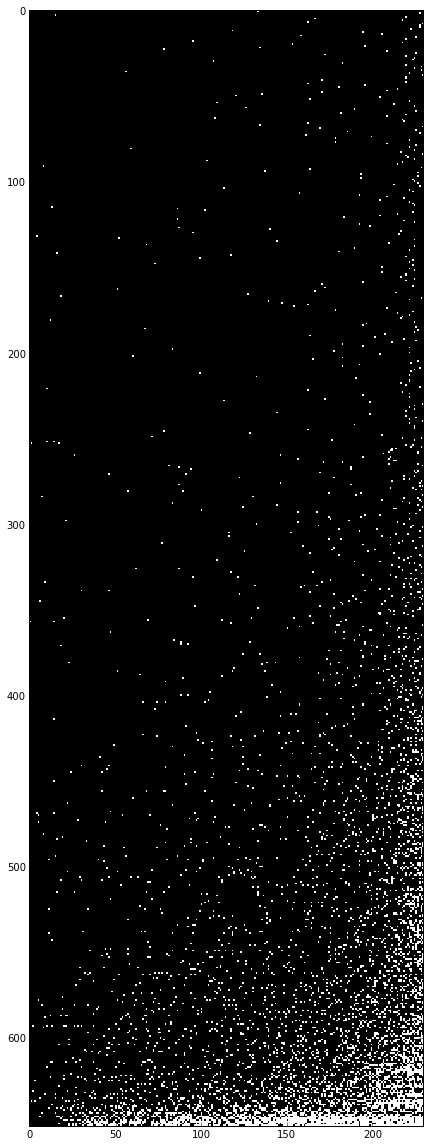

In [609]:
M_test_triangular(M)

In [462]:
M_sort.argsort(axis=1)

array([[  0, 144, 145, ...,  60, 135, 160],
       [  0, 144, 145, ...,  28,  47, 113],
       [  0, 146, 147, ...,  91, 105,  50],
       ..., 
       [  0, 139, 140, ..., 193,  27,  50],
       [  0, 143, 144, ..., 147, 179, 168],
       [  0, 146, 147, ...,  72, 229, 139]])

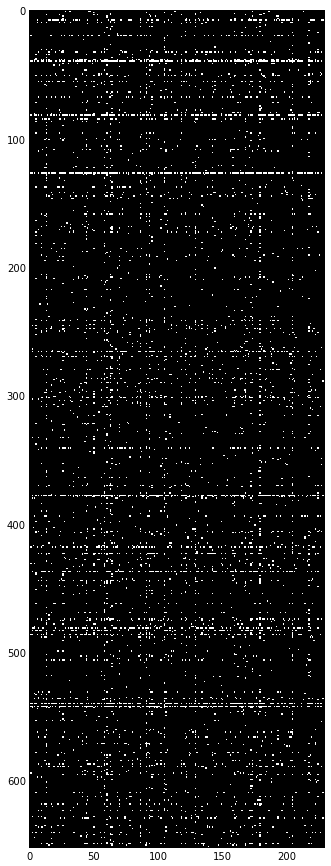

In [455]:
plotM(M_sort)

In [394]:
M.sort(axis=1, order=user_edits_order)

ValueError: Cannot specify order when the array has no fields.

In [ ]:
fems = make_co

In [632]:
cum_edits = make_cum_edit_series(sar)

In [555]:
cum_edits.head()

2001-08-31 23:37:28    1
2001-09-01 05:09:28    2
2001-09-18 10:01:17    3
2001-10-27 06:52:45    4
2001-10-27 07:01:45    5
Name: edits, dtype: int64

In [565]:
cum_edits.tail()

2014-01-29 16:05:15    53254
2014-01-29 16:07:09    53255
2014-01-29 16:11:43    53256
2014-01-29 18:09:44    53257
2014-01-29 18:12:09    53258
Name: edits, dtype: int64

In [568]:
dates

[Timestamp('2006-06-04 04:46:22', tz=None),
 Timestamp('2007-01-28 23:53:02', tz=None),
 Timestamp('2007-09-16 10:52:02', tz=None),
 Timestamp('2008-04-28 21:20:40', tz=None),
 Timestamp('2009-04-12 22:07:13', tz=None),
 Timestamp('2010-04-09 18:45:37', tz=None),
 Timestamp('2011-03-28 23:38:12', tz=None),
 Timestamp('2012-05-24 13:44:35', tz=None),
 Timestamp('2013-03-05 17:57:29', tz=None),
 Timestamp('2014-01-29 16:05:15', tz=None)]

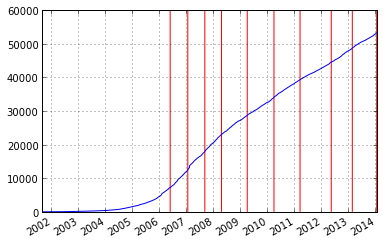

In [640]:
ax = cum_edits.plot()
ymin, ymax = ax.get_ylim()
ax.vlines(x=dates, ymin=ymin, ymax=ymax-1, color='r')

In [613]:
def plot_cum_edit_series(sar):
    '''sar should be an *sorted* by date, all_revisions dataframe like one made by make_revision_df'''
    sar['row'] = 1
    sar['edits'] = cumsum(sar['row'])
    edits = sar['edits']
    edits.plot()

In [47]:
def make_contributor_matrix(category_name=None, outlinks_page_name=None, as_df=False, wp=enwp):

    if category_name:
        cat = pywikibot.Category(wp, category_name)
        articles = list(cat.articles())
        save_name = category_name
    if outlinks_page_name:
        outlinks = pagegenerators.LinkedPageGenerator(pywikibot.Page(wp, outlinks_page_name))
        articles = filter(lambda page: page.namespace() == 0, outlinks)
        save_name = outlinks_page_name
    
    load_article_revisions(articles, wp)

    contributor_df = make_dataframe(articles)
    
    save_name = save_name.replace('/', '___')
    filename = 'savedata/' + save_name + unicode(datetime.datetime.now())
    
    minimum_edits_df = minimum_edits(contributor_df)
    
    minimum_matrix = minimum_edits_df.as_matrix()
    
    np.save(filename, minimum_matrix)
    
    if as_df:
        return minimum_edits_df
    else:
        return minimum_matrix

In [48]:
def load_article_revisions(articles, wp):
    def earliest_revision(article):
        revisions  = list(article._revisions.itervalues())
        timestamps = map(lambda r: r.timestamp, revisions)
        earliest = min(timestamps)
        return earliest
    
    def load_all_revisions(article, wp):
        before_count = len(article._revisions)
        #print "before ", before_count
        if before_count == 0:
            article.getVersionHistory()
        else:
            wp.loadrevisions(page=article, starttime=earliest_revision(article))
        after_count = len(article._revisions)
        #print "after ", after_count
        if before_count == after_count:
            return
        else:
            load_all_revisions(article, wp)
        
    map(lambda article: load_all_revisions(article, wp), articles)

In [14]:
def make_dataframe(articles):
    contributor_dict = make_dict_contributors(articles)
    contributor_df = pd.DataFrame.from_dict(data = contributor_dict, orient='index')
    contributor_df = contributor_df.fillna(value=0)
    contributor_df = contributor_df.convert_objects(convert_numeric=True)
    
    return contributor_df

In [15]:
def minimum_edits(contributor_df, minimum=25):
    mrows = contributor_df[contributor_df.apply(lambda row: any(row > 25), axis=1)]
    #and now we have to clean to columns which are articles that no one contributed to in our remaining group
    minimum_edits_df = mrows.loc[:,mrows.apply(lambda col: any(col > 0), axis=0)]
    return minimum_edits_df

In [ ]:
def no_bots(contributor_df):
    mrows = contributor_df[contributor_df.apply(lambda row: any(row > 25), axis=1)]
    #and now we have to clean to columns which are articles that no one contributed to in our remaining group
    minimum_edits_df = mrows.loc[:,mrows.apply(lambda col: any(col > 0), axis=0)]
    return no_bots_df

In [86]:
mcontribs = list(enwp.usercontribs(user='Woland1234', namespaces=[0], total=None, step=500))

[Timestamp(2013, 8, 22, 22, 13, 28),
 Timestamp(2013, 5, 18, 6, 51, 20),
 Timestamp(2013, 5, 18, 6, 50, 14),
 Timestamp(2013, 5, 18, 6, 47, 30),
 Timestamp(2013, 3, 12, 1, 8, 24),
 Timestamp(2013, 3, 12, 1, 5, 32),
 Timestamp(2013, 3, 12, 0, 55, 49),
 Timestamp(2013, 3, 12, 0, 46, 36),
 Timestamp(2013, 3, 12, 0, 42, 4),
 Timestamp(2013, 3, 7, 20, 47, 46),
 Timestamp(2013, 3, 7, 5, 55, 45),
 Timestamp(2013, 3, 7, 5, 54, 22),
 Timestamp(2013, 3, 7, 5, 51, 30),
 Timestamp(2013, 2, 18, 5, 42, 18),
 Timestamp(2013, 2, 2, 1, 23, 9),
 Timestamp(2012, 12, 22, 18, 23, 35),
 Timestamp(2012, 5, 22, 2, 18, 27),
 Timestamp(2012, 5, 2, 20, 44, 12),
 Timestamp(2012, 3, 11, 16, 48, 16),
 Timestamp(2012, 2, 8, 4, 58, 5),
 Timestamp(2012, 2, 8, 2, 45, 46),
 Timestamp(2012, 1, 16, 3, 30, 1),
 Timestamp(2012, 1, 16, 3, 28, 59),
 Timestamp(2012, 1, 11, 20, 2, 33),
 Timestamp(2012, 1, 2, 20, 5, 4),
 Timestamp(2012, 1, 2, 19, 33, 25),
 Timestamp(2011, 12, 31, 22, 5, 5),
 Timestamp(2011, 12, 30, 18, 45, 40),


In [113]:
amt = calculate_edit_hours('Maximilianklein')

found this many timestamps:  441
timestamps per second:  789.168527744


In [114]:
amt

27.824166666666667

In [137]:
calculate_edit_hours('Gbagri')

[[Timestamp(2011, 12, 6, 21, 33, 12), Timestamp(2011, 12, 6, 21, 37, 24), Timestamp(2011, 12, 6, 21, 40, 21), Timestamp(2011, 12, 6, 21, 41, 44), Timestamp(2011, 12, 6, 21, 43, 17), Timestamp(2011, 12, 6, 21, 46, 38), Timestamp(2011, 12, 6, 21, 49, 52), Timestamp(2011, 12, 6, 21, 53, 32), Timestamp(2011, 12, 6, 21, 55, 18), Timestamp(2011, 12, 6, 22, 5, 20), Timestamp(2011, 12, 6, 22, 6, 39), Timestamp(2011, 12, 6, 22, 7, 34), Timestamp(2011, 12, 6, 22, 13, 44), Timestamp(2011, 12, 6, 22, 17, 19), Timestamp(2011, 12, 6, 22, 22, 59), Timestamp(2011, 12, 6, 22, 23, 34), Timestamp(2011, 12, 6, 22, 26, 40)]]
[datetime.timedelta(0, 3478)]
timestamps per second:  91.4602981606
<type 'datetime.timedelta'>


0.9661111111111111

In [64]:
def calculate_article_metric(article_name, metric):
    page = pywikibot.Page(enwp, article_name)
    page_text = page.get()
    wikicode = pfh.parse(page_text)
    metrics = report_actionable_metrics(wikicode)
    return metrics[metric]

In [39]:
user_hours = dict()
for user in user_dict.iterkeys():
    hours = calculate_edit_hours(user)
    print user, hours 
    user_hours[user] = hours

VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


KeyboardInterrupt: 

In [4]:
user_hours = {user: calculate_edit_hours(user) for user in user_dict

NameError: global name 'calculate_edit_hours' is not defined


acummulative snapshots 

1. make the contributor matrix, and get dates,
2. using dates make accumulative user_stats
3. make article stats accumulative
    3.3 aggregate

it'd be quicker to calculate user timestamps if we could ssh tunnel then this is quick on the sever

    maximilianklein@tools-login:~$ python
    Python 2.7.3 (default, Sep 26 2013, 20:03:06) 
    [GCC 4.6.3] on linux2
    Type "help", "copyright", "credits" or "license" for more information.
    >>> import MySQLdb
    
    >>> conn = MySQLdb.connect(host='enwiki.labsdb', db="enwiki_p", port=3306, read_default_file="./replica.my.
    
how to get this working on wmflabs

    (maker)local-viafbot@tools-login:~/contagion$ jsub -mem 4g maker/bin/python ~/contagion/wiki_econ_capabil
ity/make_category_data.py

